# DIS MCEG (Duke & Owens)

In [1]:
import sys
path='../../../'
sys.path.insert(0,path)

In [8]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
#from  numba import jit,objmode,njit
from tqdm import tqdm


#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor

print(f"Corch CUDA available? '{torch.cuda.is_available()}'")
torch.cuda.empty_cache()


Corch CUDA available? 'False'


In [10]:
import params as par

In [11]:
class PDF:
    
    def __init__(self):

        self.lam2=0.4; 
        self.Q02=1; 
        self.L=torch.tensor(np.log(self.Q02/self.lam2))
        
        self.par_u=torch.tensor([ 1.12995643e-01,  2.84816039e-02,  3.49711182e-02, -1.07992996e+00,
                                 -8.67724315e-02,  2.67006979e-02, -3.42002556e-01,  2.16083133e+00,
                                 -7.06215971e-02,  5.99208979e+01, -3.80095917e+01,  6.96188257e+00,
                                 -1.93266172e+02,  1.76589359e+02, -3.96195694e+01,  1.62782187e+02,
                                 -1.79165065e+02,  4.60385729e+01],requires_grad=True)
        
        self.par_d=torch.tensor([-6.26740092e-02,  3.54363691e-01, -1.06902973e-01, -1.20394986e+00,
                                  1.55339980e-01, -7.87939114e-02,  2.75190189e-01,  3.99743001e+00,
                                 -8.40757936e-01,  4.31272688e+01, -3.26453695e+01,  7.87648066e+00,
                                 -1.02351414e+02,  1.08446491e+02, -2.81885597e+01,  2.58442965e+01,
                                 -4.35307825e+01,  1.22755848e+01],requires_grad=True)
        
    def get_s(self,Q2):
        return torch.log(torch.log(Q2/self.lam2)/self.L)

    def get_parQ2(self,par,Q2):
        s=self.get_s(Q2)
        return par[0]+par[1]*s+par[2]*s**2

    def get_pdf(self,x,Q2,par):
        A=self.get_parQ2(par[:3],Q2)
        a=self.get_parQ2(par[3:6],Q2)
        b=self.get_parQ2(par[6:9],Q2)
        c=self.get_parQ2(par[9:12],Q2)
        d=self.get_parQ2(par[12:15],Q2)
        e=self.get_parQ2(par[15:18],Q2)
        return A*x**a*(1-x)**b*(1+c*x+d*x**2+e*x**3)

    def get_u(self,x,Q2):
        return self.get_pdf(x,Q2,self.par_u)
    
    def get_d(self,x,Q2):
        return self.get_pdf(x,Q2,self.par_d)
    

In [12]:
pdf=PDF()
x=torch.tensor([0.1,0.2])
Q2=torch.tensor([5.,4.,6.])
Q2,x=torch.meshgrid(Q2,x)
test=torch.sum(pdf.get_u(x,Q2)+pdf.get_d(x,Q2))
test.backward()
print(pdf.par_u.grad)
print(pdf.par_d.grad)

tensor([ 1.7549e+02,  1.7611e+02,  1.7750e+02, -6.4104e+01, -6.4491e+01,
        -6.5163e+01, -4.5288e+00, -4.5554e+00, -4.6021e+00,  1.0591e+00,
         1.0672e+00,  1.0801e+00,  1.5085e-01,  1.5199e-01,  1.5379e-01,
         2.4074e-02,  2.4251e-02,  2.4535e-02])
tensor([ 1.0499e+02,  1.0530e+02,  1.0608e+02, -4.0563e+01, -4.0825e+01,
        -4.1267e+01, -2.7391e+00, -2.7562e+00, -2.7854e+00,  8.3464e-01,
         8.4148e-01,  8.5204e-01,  1.1508e-01,  1.1600e-01,  1.1743e-01,
         1.7832e-02,  1.7971e-02,  1.8189e-02])


/Users/attia/AHMED_HOME/Research/Projects/DA/QuantOm_HMC/Code/approximate_sampling_gradients/theory/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


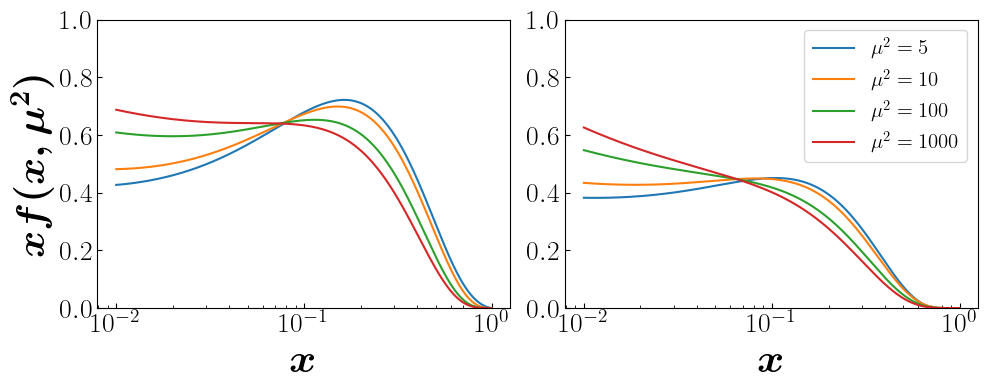

In [13]:
nrows,ncols=1,2;AX=[]
fig = py.figure(figsize=(ncols*5,nrows*4))

pdf=PDF()

x=10**torch.linspace(-2,np.log10(0.99),1000)
Q2=torch.tensor([5.,10.,100.,1000.])
Q2,x=torch.meshgrid(Q2,x)

ax=py.subplot(nrows,ncols,1); AX.append(ax)
xu=(x*pdf.get_u(x,Q2)).detach()
for i in range(xu.shape[0]):
    ax.plot(x[i].numpy(),xu[i].numpy(),label=r'$\mu^2=%d$'%Q2.numpy()[i,0])

ax=py.subplot(nrows,ncols,2); AX.append(ax)
xd=(x*pdf.get_d(x,Q2)).detach()
for i in range(xd.shape[0]):
    ax.plot(x[i].numpy(),xd[i].numpy(),label=r'$\mu^2=%d$'%Q2.numpy()[i,0])

for ax in AX:
    ax.semilogx()
    ax.set_ylim(0,1)
    ax.tick_params(axis='both', which='both', labelsize=20,direction='in')
    ax.set_xlabel(r'\boldmath{$x$}',size=30)
AX[0].set_ylabel(r'\boldmath{$xf(x,\mu^2)$}',size=30)
AX[1].legend(fontsize=15,loc=1)
py.tight_layout()

In [14]:
class IDIS:
    
    def __init__(self):
        self.pdf =PDF()
        
    def get_diff_xsec(self,x,Q2,rs,tar,option='xy'):
        y=Q2/(rs**2-par.M2)/x
        Yp=1+(1-y)**2
        Ym=1-(1-y)**2
        K2=(Yp+2*x**2*y**2*par.M2/Q2)
        KL=-y**2
        K3=Ym*x
        alfa=1/137

        if option=='xy': #! diff in x,y
            norm=2*np.pi*alfa**2/x/y/Q2

        if option=='xQ2':#! diff in x,Q2
            norm=2*np.pi*alfa**2/x/y/Q2*y/Q2 

        xu=x*self.pdf.get_u(x,Q2)
        xd=x*self.pdf.get_d(x,Q2)

        eU2=4/9; eD2=1/9

        if tar=='p':   
            F2=eU2*xu+eD2*xd
            FL=0
            F3=0
        elif tar=='n':
            F2=eU2*xd+eD2*xu
            FL=0
            F3=0

        xsec=norm*(K2*F2 + KL*FL + K3*F3)
        return xsec

In [15]:
idis=IDIS()
x =torch.tensor([0.1])
Q2=torch.tensor([5.])
x,Q2=torch.meshgrid(x,Q2)

rs=140; tar='p'
xsec=idis.get_diff_xsec(x,Q2,rs,tar,option='xQ2')
xsec.backward()
print(idis.pdf.par_u.grad)
print(idis.pdf.par_d.grad)

tensor([ 4.5345e-04,  4.5978e-04,  4.6619e-04, -1.8567e-04, -1.8826e-04,
        -1.9089e-04, -8.4959e-06, -8.6145e-06, -8.7347e-06,  2.4195e-06,
         2.4532e-06,  2.4874e-06,  2.4195e-07,  2.4532e-07,  2.4874e-07,
         2.4195e-08,  2.4532e-08,  2.4874e-08])
tensor([ 7.1652e-05,  7.2652e-05,  7.3666e-05, -3.0807e-05, -3.1237e-05,
        -3.1673e-05, -1.4097e-06, -1.4293e-06, -1.4493e-06,  5.1598e-07,
         5.2318e-07,  5.3048e-07,  5.1598e-08,  5.2318e-08,  5.3048e-08,
         5.1598e-09,  5.2318e-09,  5.3048e-09])


In [16]:
class MCEG:

    def __init__(self,rs=140,tar='p',W2min=10,nx=10,nQ2=10):
        self.idis=IDIS()
        self.nx=nx
        self.nQ2=nQ2
        self.tar=tar
        self.rs=rs
        self.W2min=W2min
        self.gen_xQ2_grid(nx,nQ2)
        self.gen_xsection()
        self.setup_inv_transorm_sampler(mx=10,mQ2=10)

        
    def interp(self,x: Tensor, xp: Tensor, fp: Tensor) -> Tensor:
        m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
        b = fp[:-1] - (m * xp[:-1])
        indicies = torch.sum(torch.ge(x[:, None], xp[None, :]), 1) - 1
        indicies = torch.clamp(indicies, 0, len(m) - 1)
        return m[indicies] * x + b[indicies]

    def gen_xQ2_grid(self,nx,nQ2):
        
        Q2min=par.mc2
        Q2max=self.rs**2-par.M2
        LQ2=torch.linspace(np.log(Q2min),np.log(Q2max),nQ2)
        dLQ2=LQ2[1:]-LQ2[:-1]
        LQ2mid=0.5*(LQ2[1:]+LQ2[:-1])
        LQ2max=LQ2[1:]
        LQ2min=LQ2[:-1]
        
        xmin=Q2min/(self.rs**2-par.M2)
        xmax=1
        Lx=torch.linspace(np.log(xmin),np.log(xmax),nx)
        dLx=Lx[1:]-Lx[:-1]
        Lxmid=0.5*(Lx[1:]+Lx[:-1])
        Lxmax=Lx[1:]
        Lxmin=Lx[:-1]
        
        Lxmid,LQ2mid=torch.meshgrid(Lxmid,LQ2mid)
        Lxmin,LQ2min=torch.meshgrid(Lxmin,LQ2min)
        Lxmax,LQ2max=torch.meshgrid(Lxmax,LQ2max)
        dLx,dLQ2=torch.meshgrid(dLx,dLQ2)
        

        x =torch.exp(Lxmin); Q2=torch.exp(LQ2max)
        Q2max=(self.rs**2-par.M2)*x
        cond1=Q2max>=Q2
        
        x =torch.exp(Lxmax); Q2=torch.exp(LQ2min)
        W2=par.M2+Q2/x-Q2
        cond2=W2>=self.W2min
        acc=cond1*cond2
        
        self.Lxmid=Lxmid; self.LQ2mid=LQ2mid; 
        self.Lxmin=Lxmin; self.LQ2min=LQ2min; 
        self.Lxmax=Lxmax; self.LQ2max=LQ2max; 

        self.dLx=dLx; self.dLQ2=dLQ2;
        self.acc=acc
        
    def gen_xsection(self):
        x =torch.exp(self.Lxmid); Q2=torch.exp(self.LQ2mid)
        self.dxsec=torch.zeros(x.shape)
        entries=[(a,b) for a in range(x.shape[0]) for b in range(x.shape[1])]
        #for i,j in tqdm(entries):
        #    if self.acc[i,j]==False: continue
        #    self.dxsec[i,j]=self.idis.get_diff_xsec(x[i,j],Q2[i,j],self.rs,self.tar,'xQ2')
        self.dxsec=self.idis.get_diff_xsec(x,Q2,self.rs,self.tar,'xQ2')
        self.dxsec[self.acc==False]*=0
        
        integrand=self.dxsec*(x*self.dLx)*(Q2*self.dLQ2)*self.acc
        self.total_xsec=torch.sum(integrand)
        self.weights=integrand/self.total_xsec
   
    def setup_inv_transorm_sampler(self,mx=10,mQ2=10):
        entries01 = [(a,b) for a in range(self.Lxmid.shape[0]) for b in range(self.Lxmid.shape[1])]        
        entries10 = [(a,b) for a in range(self.Lxmid.shape[1]) for b in range(self.Lxmid.shape[0])]
        grid=self.Lxmin.shape
        
        #print('grid',grid)
  
        ## x dimesion
        Lxmin=self.Lxmin[:,0].reshape(-1,1)
        dLx=self.dLx[:,0].reshape(-1,1)
        u=torch.linspace(0,1,mx)
        x=torch.exp((Lxmin+u*dLx)).flatten()
        xbins=x.reshape(-1,mx)
        #print('xbins',xbins.shape)
        Q2=torch.exp(self.LQ2min.T[:,0]).flatten()

        Q2,x=torch.meshgrid(Q2,x)
        xsecx=self.idis.get_diff_xsec(x,Q2,self.rs,self.tar,'xQ2') 
        #print('xsecx',xsecx.shape)
        xsecx=xsecx.reshape(grid[1],-1,mx)
        #print('xsecx',xsecx.shape)

        normx=torch.zeros((grid[1],grid[0]))
        #print('normx',normx.shape)
        for i,j in tqdm(entries10):
            normx[i,j]=torch.trapezoid(xsecx[i,j],xbins[j])       

        rhox=torch.zeros(xsecx.shape)
        #print('rhox',rhox.shape)
        for i,j in tqdm(entries10):
            if self.acc[j,i]==True:
                rhox[i,j]=xsecx[i,j]/normx[i,j]   
                
        cdfx=torch.zeros(xsecx.shape)
        #print('cdfx',cdfx.shape)
        for i,j in tqdm(entries10):
            if self.acc[j,i]==True:
                for k in range(mx):
                    cdfx[i,j,k]=torch.trapezoid(rhox[i,j,k:],xbins[j,k:])
        self.cdfx=cdfx
        self.xbins=xbins
        
        
        ## Q2 dimesion
        LQ2min=self.LQ2min.T[:,0].reshape(-1,1)
        dLQ2=self.dLQ2.T[:,0].reshape(-1,1)
        u=torch.linspace(0,1,mQ2)
        Q2=torch.exp((LQ2min+u*dLQ2)).flatten()
        Q2bins=Q2.reshape(-1,mQ2)
        #print('Q2bins',Q2bins.shape)
        x=torch.exp(self.Lxmin[:,0]).flatten()

        x,Q2=torch.meshgrid(x,Q2)
        xsecQ2=self.idis.get_diff_xsec(x,Q2,self.rs,self.tar,'xQ2') 
        #print('xsecQ2',xsecQ2.shape)
        xsecQ2=xsecQ2.reshape(grid[0],-1,mQ2)
        #print('xsecQ2',xsecQ2.shape)

        normQ2=torch.zeros((grid[0],grid[1]))
        #print('normQ2',normQ2.shape)
        for i,j in tqdm(entries01):
            normQ2[i,j]=torch.trapezoid(xsecQ2[i,j],Q2bins[j])   
            
        rhoQ2=torch.zeros(xsecQ2.shape)
        #print('rhoQ2',rhoQ2.shape)
        for i,j in tqdm(entries01):
            if self.acc[i,j]==True:
                rhoQ2[i,j]=xsecQ2[i,j]/normQ2[i,j]   
                
        cdfQ2=torch.zeros(xsecQ2.shape)
        #print('cdfQ2',cdfQ2.shape)
        for i,j in tqdm(entries01):
            if self.acc[i,j]==True:
                for k in range(mx):
                    cdfQ2[i,j,k]=torch.trapezoid(rhoQ2[i,j,k:],Q2bins[j,k:])
        self.cdfQ2=cdfQ2
        self.Q2bins=Q2bins
        
    def gen_events(self,N,verb=False):
        n=torch.tensor(self.weights*N,dtype=int)
        evts=torch.zeros(2,N)
        entries = [(a,b) for a in range(self.Lxmid.shape[0]) 
                         for b in range(self.Lxmid.shape[1])]
        
        cnt=0
        for i,j in tqdm(entries):
            if self.acc[i,j]==False: continue        
            evts[0,cnt:n[i,j]+cnt]=self.interp(torch.rand(n[i,j]),torch.flip(self.cdfx[j,i],dims=(0,))
                                                                 ,torch.flip(self.xbins[i],dims=(0,)))
            evts[1,cnt:n[i,j]+cnt]=self.interp(torch.rand(n[i,j]),torch.flip(self.cdfQ2[i,j],dims=(0,))
                                                                 ,torch.flip(self.Q2bins[j],dims=(0,)))
                       
            cnt+=n[i,j]
        
        evts=evts.T
        evts=evts[evts[:,0]>0]

        if verb:
            print(self.total_xsec)
            ax=py.subplot(111)
            ax.plot(np.log(evts[:,0].detach().numpy()),np.log(evts[:,1].detach().numpy()),'r.')
            ax.plot(self.Lxmid[self.acc].detach().numpy(),self.LQ2mid[self.acc].detach().numpy(),'k.')
            ax.set_xlim(-10,0)
            ax.set_ylim(0,None)
            ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
            ax.set_ylabel(r'$Q^2$',size=30)
            ax.set_xlabel(r'$x$',size=30)
            ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
            ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
            ax.set_yticks(np.log([10,100,1000,10000]))
            ax.set_yticklabels([r'$10$',r'$100$',r'$1000$',r'$10000$']);
            py.show()
        
        return evts

In [17]:
nx=30; nQ2=20
mceg=MCEG(rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
evts=mceg.gen_events(100,verb=False)
test=torch.sum(evts)
test.backward()
print(mceg.idis.pdf.par_u.grad)
print(mceg.idis.pdf.par_d.grad)

100%|█████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 9414.96it/s]
/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 17238.62it/s]


tensor([-5.2566e+00,  4.6785e+00,  9.9167e+00,  5.0977e-01, -5.1749e+00,
        -8.0437e+00,  1.4298e-03, -6.3397e-02, -1.0884e-01,  6.7307e-03,
         2.6009e-02,  3.9113e-02,  7.0627e-04,  2.2638e-03,  3.5091e-03,
         1.0087e-04,  2.8051e-04,  4.4104e-04])
tensor([-1.8841e+00,  5.0334e-01,  1.7074e+00, -4.8755e-01, -1.3852e+00,
        -1.8378e+00, -4.4207e-03, -1.2863e-02, -1.9217e-02,  3.3229e-03,
         6.5255e-03,  8.8769e-03,  2.5475e-04,  5.1627e-04,  7.4143e-04,
         2.8115e-05,  5.8942e-05,  8.8024e-05])


100%|█████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 9490.82it/s]
/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 17299.27it/s]


tensor(0.0006, grad_fn=<SumBackward0>)


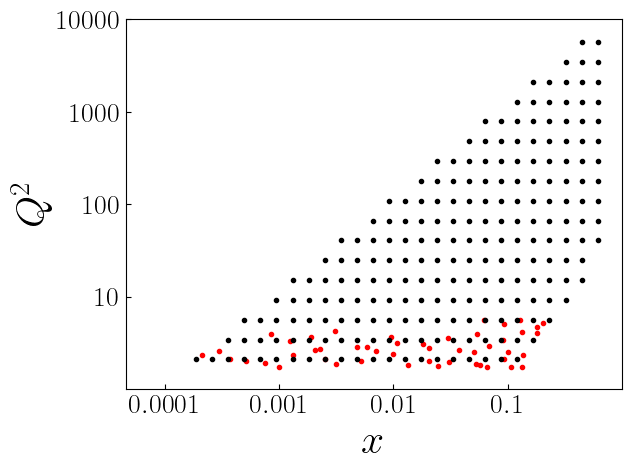

/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 15491.87it/s]

tensor(0.0006, grad_fn=<SumBackward0>)


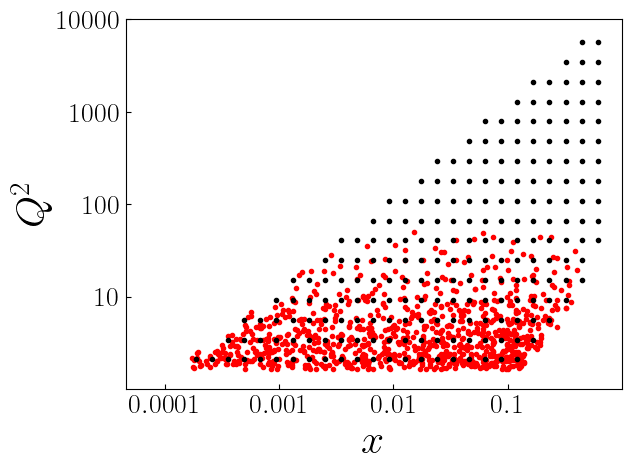

/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|█████████████████████████████████████████████████████████████████| 551/551 [00:00<00:00, 7293.45it/s]


tensor(0.0006, grad_fn=<SumBackward0>)


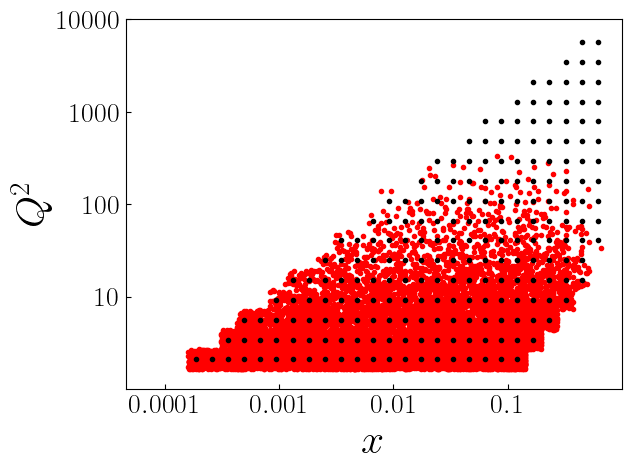

In [18]:
nx=30; nQ2=20
mceg=MCEG(rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
mceg.gen_events(100,verb=True);
mceg.gen_events(1000,verb=True);
mceg.gen_events(10000,verb=True);

In [19]:
nx=100; nQ2=100
mceg=MCEG(rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 

100%|███████████████████████████████████████████████████████████████| 9801/9801 [00:01<00:00, 8536.46it/s]


In [20]:
evts=mceg.gen_events(1000000,verb=False)
mceg.total_xsec

/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|██████████████████████████████████████████████████████████████| 9801/9801 [00:00<00:00, 14471.01it/s]


tensor(0.0007, grad_fn=<SumBackward0>)

In [21]:
hist=np.histogram2d(np.log(evts[:,0].detach().numpy())
                   ,np.log(evts[:,1].detach().numpy()),bins=(50,50))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
for i,j in tqdm((a,b) for a in range(hist[1].shape[0]-1) 
                      for b in range(hist[2].shape[0]-1)):
    if hist[0][i,j]>0: 
        x=torch.tensor(np.exp(0.5*(hist[1][i]+hist[1][i+1])))
        Q2=torch.tensor(np.exp(0.5*(hist[2][j]+hist[2][j+1])))
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2').detach().numpy()
        
        dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        reco[i,j]=hist[0][i,j]/dx/dQ2

reco*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])

2500it [00:00, 4219.35it/s]


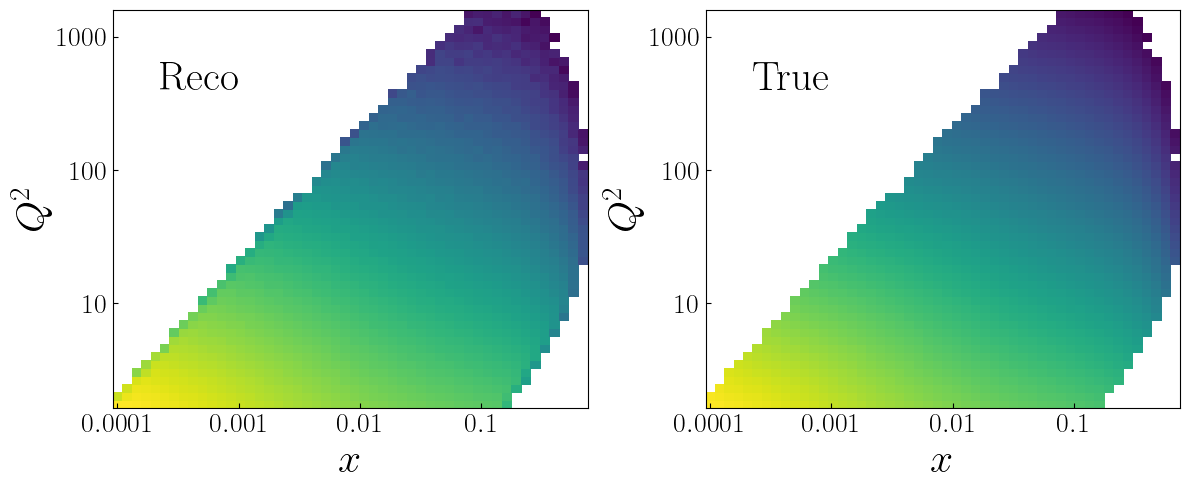

In [22]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],reco.T, norm=matplotlib.colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
c=ax.pcolor(hist[1],hist[2],true.T, norm=matplotlib.colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2653222341.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2653222341.py:9: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())


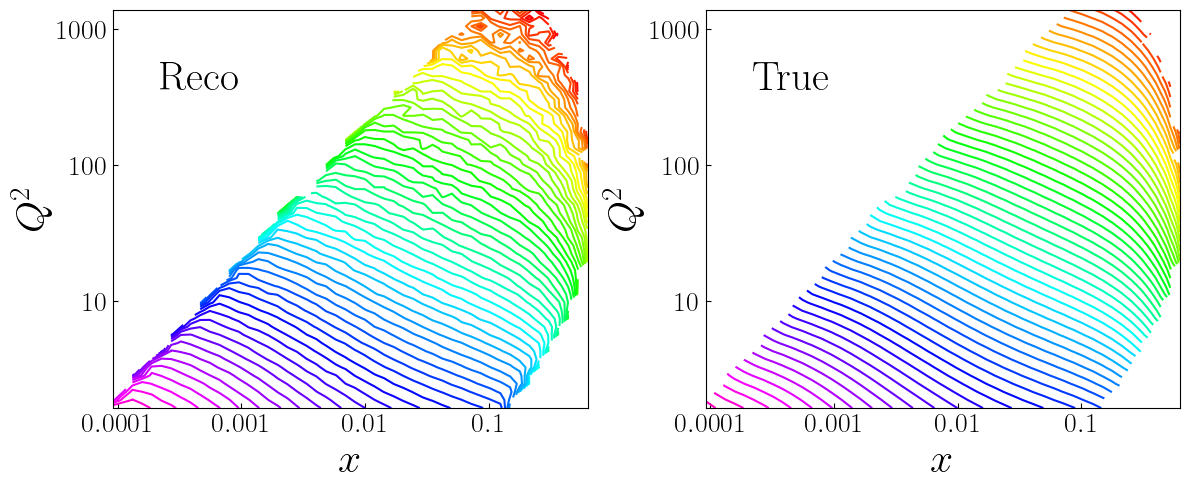

In [23]:
nrows,ncols=1,2; AX=[]
fig = py.figure(figsize=(ncols*6,nrows*5))
cmap='gist_rainbow'

ax=py.subplot(nrows,ncols,1);AX.append(ax)
levels=10**np.linspace( np.log10(np.amin(reco[reco>0])),np.log10(np.amax(reco)),60)
cs = ax.contour(hist[1][:-1],hist[2][:-1],reco.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
ax=py.subplot(nrows,ncols,2);AX.append(ax)
cs = ax.contour(hist[1][:-1],hist[2][:-1],true.T,levels=levels,cmap=cmap,norm=colors.LogNorm())
for ax in AX:
    ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
    ax.set_ylabel(r'$Q^2$',size=30)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
    ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
    ax.set_yticks(np.log([10,100,1000]))
    ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
AX[0].text(0.1,0.8,r'$\rm Reco$',transform=AX[0].transAxes,size=30)
AX[1].text(0.1,0.8,r'$\rm True$',transform=AX[1].transAxes,size=30)
py.tight_layout()

In [24]:
nx=100; nQ2=300
mceg=MCEG(rs=140,tar='p',W2min=10,nx=nx,nQ2=nQ2) 
evts=mceg.gen_events(1000000,verb=False)
mceg.total_xsec

100%|█████████████████████████████████████████████████████████████| 29601/29601 [00:03<00:00, 8505.35it/s]
/var/folders/yt/fk4rtjk52hs5_dppv7266sf80000gn/T/ipykernel_23539/2884597895.py:155: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n=torch.tensor(self.weights*N,dtype=int)
100%|████████████████████████████████████████████████████████████| 29601/29601 [00:02<00:00, 14312.17it/s]


tensor(0.0007, grad_fn=<SumBackward0>)

In [25]:
hist=np.histogram2d(np.log(evts[:,0].detach().numpy()),np.log(evts[:,1].detach().numpy()),bins=(nx,nQ2))
true=np.zeros(hist[0].shape)
reco=np.zeros(hist[0].shape)
stat=np.zeros(hist[0].shape)
entries=[(a,b) for a in range(hist[1].shape[0]-1) 
               for b in range(hist[2].shape[0]-1)]
for i,j in tqdm(entries):
    if hist[0][i,j]>0: 
        x=torch.tensor(np.exp(0.5*(hist[1][i]+hist[1][i+1])))
        Q2=torch.tensor(np.exp(0.5*(hist[2][j]+hist[2][j+1])))
        xmin =np.exp(hist[1][i]); xmax=np.exp(hist[1][i+1])
        Q2min=np.exp(hist[2][j]); Q2max=np.exp(hist[2][j+1])
        #dx=np.exp(hist[1][i+1])-np.exp(hist[1][i])
        #dQ2=np.exp(hist[2][j+1])-np.exp(hist[2][j])
        dx=xmax-xmin
        dQ2=Q2max-Q2min
        
        
        #itg_xQ2=np.vectorize(lambda x,Q2:idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2'))
        ##itg_x=lambda x: quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max)[0]
        ##true[i,j]=quad(itg_x,xmin,xmax)[0]/dx/dQ2
        #itg_x=np.vectorize(lambda x: fixed_quad(lambda Q2: itg_xQ2(x,Q2),Q2min,Q2max,n=10)[0])
        #true[i,j]=fixed_quad(itg_x,xmin,xmax,n=10)[0]/dx/dQ2
        
        true[i,j]=idis.get_diff_xsec(x,Q2,mceg.rs,mceg.tar,'xQ2').detach().numpy()
        
        reco[i,j]=hist[0][i,j]/dx/dQ2
        stat[i,j]=np.sqrt(hist[0][i,j])/dx/dQ2
        

reco*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])
stat*=mceg.total_xsec.detach().numpy()/np.sum(hist[0])

100%|█████████████████████████████████████████████████████████████| 30000/30000 [00:07<00:00, 4245.77it/s]


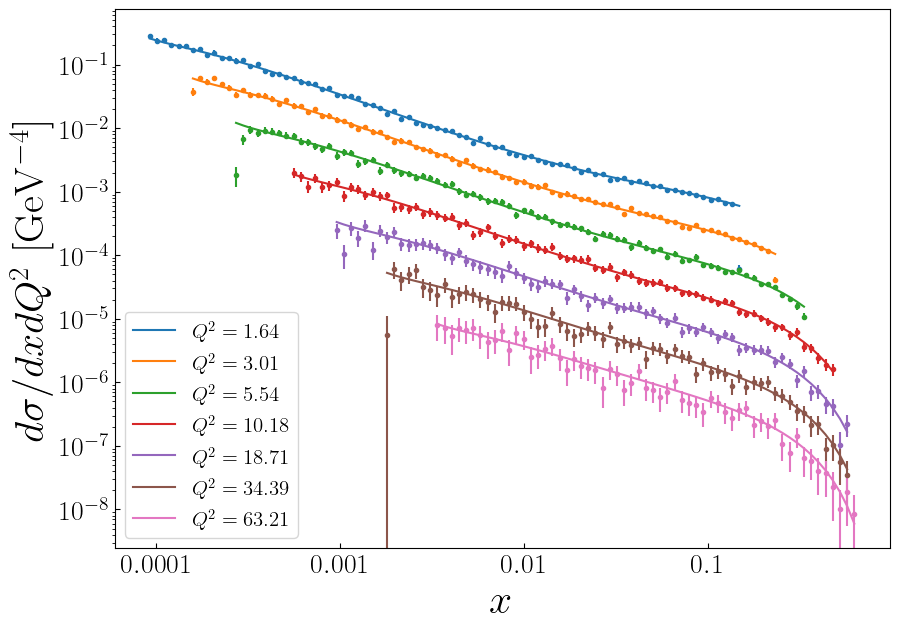

In [26]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*10,nrows*7))
ax=py.subplot(nrows,ncols,1)
nQ2_selects=10
dnQ2=int(hist[2].shape[0]/nQ2_selects)
for j in range(0,hist[2].shape[0]-1,dnQ2):
    if np.exp(hist[2][j])>100: continue
    cond=true[:,j]>0
    h,=ax.plot(hist[1][:-1][cond],true[:,j][cond],label=r'$Q^2=%0.2f$'%np.exp(hist[2][j]))
    cond=reco[:,j]>0
    #h,=ax.plot(hist[1][:-1][cond],reco[:,j][cond],'k:')
    ax.errorbar(hist[1][:-1][cond],reco[:,j][cond],stat[:,j][cond],fmt='.',color=h.get_color())
ax.tick_params(axis='both', which='major', labelsize=20,direction='in')
ax.set_ylabel(r'$d\sigma/dxdQ^2~[{\rm GeV^{-4}}]$',size=30)
ax.set_xlabel(r'$x$',size=30)
ax.set_xticks(np.log([1e-4,1e-3,1e-2,1e-1]))
ax.set_xticklabels([r'$0.0001$',r'$0.001$',r'$0.01$',r'$0.1$'])
#ax.set_yticks(np.log([10,100,1000]))
#ax.set_yticklabels([r'$10$',r'$100$',r'$1000$']);
ax.semilogy();
ax.legend(fontsize=15)